# TensorFlow Core Learning Algorithms
* Linear Regression
* Classification
* Clustering
* Hidden Markov Models

## Linear Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np

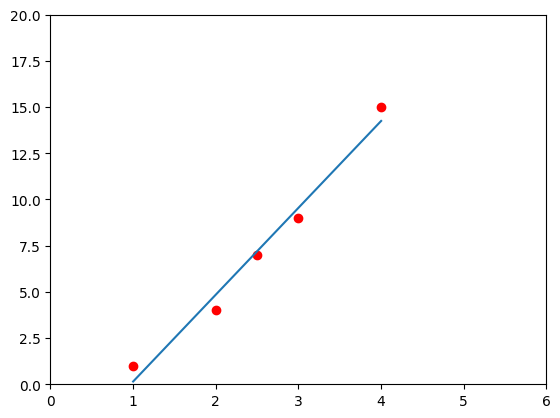

In [2]:
x = [1,2,2.5,3,4]
y = [1,4,7,9,15]

plt.plot(x, y, "ro")  # red circles for the points
plt.axis([0,6,0,20])

plt.plot(np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)))
plt.show()

In [3]:
np.polyfit(x,y,1),np.poly1d(np.polyfit(x,y,1)),np.poly1d(np.polyfit(x,y,1))(np.unique(x))

(array([ 4.7 , -4.55]),
 poly1d([ 4.7 , -4.55]),
 array([ 0.15,  4.85,  7.2 ,  9.55, 14.25]))

### Setup and Import

In [5]:
# %pip install -q sklearn
# %pip install --upgrage tensorflow
# %pip install ipython

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.13.1


In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc 
import tensorflow as tf

### Data

In [7]:
# load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

y_train = dftrain.pop("survived")  # remove column
y_eval = dfeval.pop("survived")

In [26]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.28,First,C,Cherbourg,n
2,female,26.0,0,0,7.92,Third,unknown,Southampton,y
3,female,35.0,1,0,53.10,First,C,Southampton,n
4,male,28.0,0,0,8.46,Third,unknown,Queenstown,y


In [25]:
pd.set_option("display.precision", 2)
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.00,627.00,627.00,627.00
mean,29.63,0.55,0.38,34.39
std,12.51,1.15,0.79,54.60
min,0.75,0.00,0.00,0.00
25%,23.00,0.00,0.00,7.90
50%,28.00,0.00,0.00,15.05
75%,35.00,1.00,0.00,31.39
max,80.00,8.00,5.00,512.33


In [17]:
print(y_train)

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64


In [20]:
print(dftrain.loc[0], y_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [21]:
dftrain.shape

(627, 9)

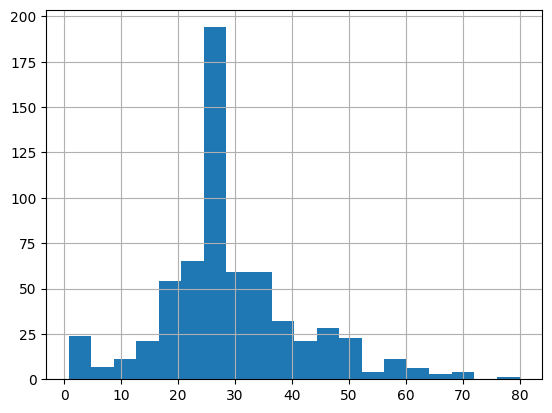

In [35]:
dftrain["age"].hist(bins=20)
plt.show()

<Axes: ylabel='sex'>

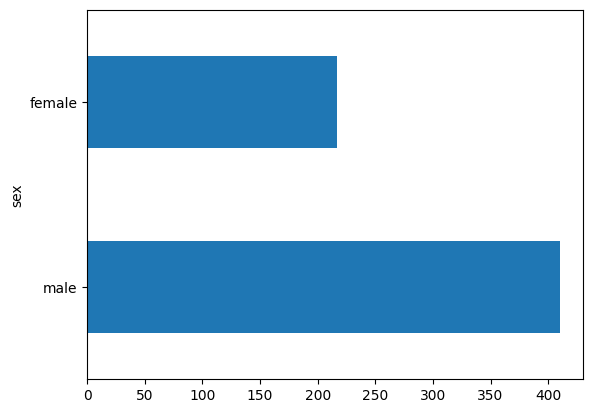

In [36]:
dftrain.sex.value_counts().plot(kind="barh")

<Axes: ylabel='class'>

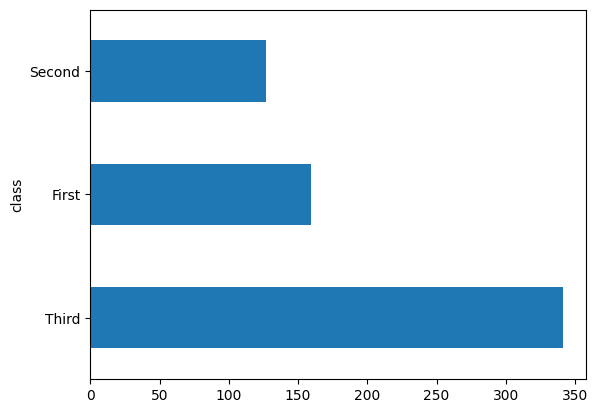

In [38]:
dftrain["class"].value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

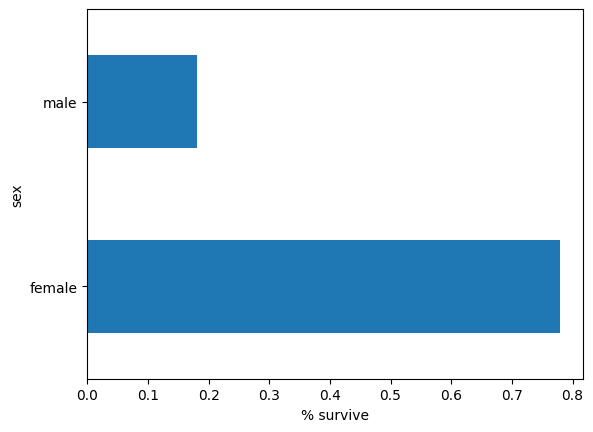

In [41]:
pd.concat([dftrain, y_train], axis=1).groupby("sex").survived.mean().plot(kind="barh").set_xlabel(r"% survive")

#### Conclusion
* the majority of passengers are in their 20's or 30's
* the majority of passengers are male
* the majority of passengers are in "Third" class
* females have a nuch higher chance of survival

### Training and Testing

In [42]:
dfeval.shape

(264, 9)

### Freature Column

In [43]:
dftrain.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [54]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
       'embark_town', 'alone']
NUMERIC_COLUMNS = ["age", "fare"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
       vocabulary = dftrain[feature_name].unique()
       feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
       feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(*feature_columns, sep="\n")

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_va

In [50]:
dftrain.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

### The Training Process

### Input Function

In [69]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        # inner function, this will be returned
        # create tf.data.Dataset object
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))

        # randomize order of data
        if shuffle:
            ds = ds.shuffle(buffer_size=len(data_df))

        # split dataset into batches of 32 and repeat process for number of epochs
        ds = ds.batch(batch_size).repeat(num_epochs)

        # return a batch of the dataset
        return ds 
        
    # return a function objectt for use
    return input_function

In [70]:
# call the input function that was returned  to us to get a dataset
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False)

### Creating The Model

In [72]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)

# get model metrics/stats by testing on testing data
result = linear_est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zuoch\\AppData\\Local\\Temp\\tmpvae1j11s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorf

In [79]:
# cleas console output
clear_output()
print(result["accuracy"])

# the result variable is simply a dict of stats about model
print(result)

0.7537879
{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8365473, 'auc_precision_recall': 0.7874541, 'average_loss': 0.47384772, 'label/mean': 0.375, 'loss': 0.4667773, 'precision': 0.67346936, 'prediction/mean': 0.38079375, 'recall': 0.6666667, 'global_step': 200}


In [81]:
result = list(linear_est.predict(eval_input_fn))

print("\n", result)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\zuoch\AppData\Local\Temp\tmpvae1j11s\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

 [{'logits': array([-2.5606525], dtype=float32), 'logistic': array([0.0717141], dtype=float32), 'probabilities': array([0.9282859, 0.0717141], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1]), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-0.70615053], dtype=float32), 'logistic': array([0.33045], dtype=float32), 'probabilities': array([0.66955   , 0.33044997], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1]), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([0.74484396], dtype=float32), 'logistic': array([0.67805415], dtype=float32), 'pr

In [87]:
from pprint import pprint
pprint(result[0])

{'all_class_ids': array([0, 1]),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.0717141], dtype=float32),
 'logits': array([-2.5606525], dtype=float32),
 'probabilities': array([0.9282859, 0.0717141], dtype=float32)}


In [92]:
print(dfeval.loc[0])
print(y_eval[0])
print(result[0]["probabilities"][1])

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0
0.071714096


## Classification

In [93]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import pandas as pd

In [94]:
CSV_COLUMN_NAMES = ["SepalLength", "Sepalwidth", "PetalLength", "PetalWidth", "Species"]
SPECIES = ["Setosa", "Versicolor", "virginica"]

In [97]:
train_path = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")

test_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

In [110]:
# use keras (a module inside of TensorFlow) to grap datasets and read them into a pandas dataframe
train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

In [105]:
train.head()

,SepalLength,Sepalwidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [111]:
train_y = train.pop("Species")
test_y = test.pop("Species")

# the Species column is gone
train.head()

,SepalLength,Sepalwidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [107]:
train.shape

(120, 4)

In [108]:
train_y.head()

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [112]:
def input_fn(features, labels, training=True, batch_size=256):
    # convert the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # shuffle and repeat if you are in training mode
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

### Feature Columns

In [113]:
# feature columns describe how to use the input
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

In [114]:
my_feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Sepalwidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Building Model
* `DNNClassifier`
* `LinearClassifier`

In [122]:
# build a DNN with 2 hidden layers with 30 and 10 hidden nodes each
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # two hidden layers of 30 and 10 nodes respectively
    hidden_units=[30,10],
    # the model must choose between 3 classes
    n_classes=3
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\zuoch\\AppData\\Local\\Temp\\tmpu1u65q76', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [132]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=(len(my_feature_columns),)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

classifier.compile(optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
    )

### Training

In [133]:
classifier.fit(train, train_y, epochs=10)

Epoch 1/10


4/4 [==============================] - 1s 5ms/step - loss: 1.1581 - accuracy: 0.4583
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 1.0576 - accuracy: 0.7000
Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.9881 - accuracy: 0.7000
Epoch 4/10
4/4 [==============================] - 0s 421us/step - loss: 0.9306 - accuracy: 0.7000
Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8769 - accuracy: 0.7000
Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.8294 - accuracy: 0.7000
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 0.7874 - accuracy: 0.7000
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7522 - accuracy: 0.7000
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7226 - accuracy: 0.7000
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 0.6987 - accuracy: 0.7000


In [139]:
loss, accuracy = classifier.evaluate(test, test_y)
print(f"Test set accuracy: {accuracy:.4f}")

1/1 [==============================] - 0s 33ms/step - loss: 0.8101 - accuracy: 0.5333
Test set accuracy: 0.5333


In [141]:
def input_fn(features, batch_size=256):
    # convert the inputs to a Dataset without labels
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [163]:
features = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]
predict = {}

print("Please type numeric values as prompted")
for feature in features:
    valid = True
    while valid:
        val = input(feature + ": ")
        if val.isdigit():
            valid = False

    predict[feature] = [float(val)]

predict_values = np.array(list(predict.values())).reshape(1, -1)

predictions = classifier.predict(predict_values)

for pred_dict in predictions:
    class_id = np.argmax(pred_dict[0])
    probability = pred_dict[class_id]

    print(f"Prediction is {SPECIES[class_id]} | ({100*probability:.1f}%)")


Please type numeric values as prompted
[[  23. 2342.   43.  234.]]
1/1 [==============================] - 0s 19ms/step
Prediction is Setosa | (100.0%)


In [151]:
predict

{'SepalLength': [22.0],
 'SepalWidth': [3.0],
 'PetalLength': [44.0],
 'PetalWidth': [1.0]}

## Clustering

## Hidden Markov Models

### Imports and Setup

In [6]:
%pip install tensorflow --upgrade

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

### Wether Model

In [3]:
tfd = tfp.distributions

initial_distribution = tfd.Categorical(probs=[0.8,0.2])
transition_distribution = tfd.Categorical(probs=[[0.7,0.3],[0.2,0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

In [5]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7
)

In [7]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:
    print(mean.numpy())

[3.        5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]
